# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Reframed:
_Our data task is to build a model that predicts the asking or sold price of a used car. This model will be trained on a dataset containing information on millions of used cars, including features like make, model, year, mileage, condition, and features. By analyzing the relationships between these features and car price, we can identify the most significant factors influencing a car's value in the used car market._

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error

import warnings

In [2]:
cars_df = pd.read_csv('data/vehicles.csv')
cars_df.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
184418,7303623012,eastern shore,24590,2018.0,lincoln,mkz select sedan 4d,good,NaN,gas,16081.0,clean,automatic,3LN6L5C91JR615484,fwd,NaN,sedan,white,md
127022,7303788852,savannah / hinesville,57850,2016.0,chevrolet,corvette,NaN,NaN,gas,1281.0,clean,automatic,1G1YD3D77G5115393,NaN,NaN,coupe,NaN,ga
297257,7307254972,columbus,2200,2003.0,honda,civic,good,4 cylinders,gas,240000.0,clean,automatic,NaN,fwd,compact,sedan,black,oh
393030,7315987725,norfolk / hampton roads,7500,2005.0,chrysler,crossfire limited,excellent,6 cylinders,gas,51286.0,rebuilt,manual,NaN,rwd,NaN,NaN,NaN,va
424009,7311246291,milwaukee,4999,2008.0,nissan,rogue,like new,4 cylinders,gas,159369.0,clean,automatic,NaN,4wd,NaN,wagon,NaN,wi


In [3]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
cars_df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


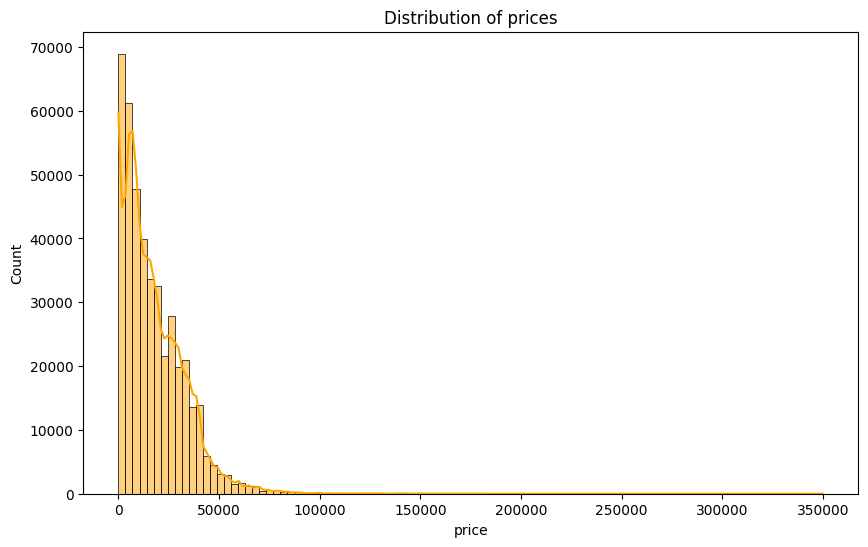

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(cars_df.query('price < 400000'), x="price", kde=True, bins=100, color='orange' )
plt.title('Distribution of prices')
plt.show()

In [6]:
numerical_features = ['price', 'year', 'odometer']

In [7]:
# Check % of missing values
missing_values = cars_df.isna().sum()
missing_values_percentage = missing_values / cars_df.shape[0] * 100

# convert to dataframe
missing_values_percentage = pd.DataFrame(missing_values_percentage, columns=['% missing values'])
missing_values_percentage


,% missing values
id,0.000000
region,0.000000
price,0.000000
year,0.282281
manufacturer,4.133714
model,1.236179
condition,40.785232
cylinders,41.622470
fuel,0.705819
odometer,1.030735


Given the high percentage of missing values for VIN (>37%) and size (>70%), let's drop these columns.

In [8]:
# Drop columns 'VIN' and 'size'
cars_df = cars_df.drop(columns=['VIN', 'size'])

# Set index to 'id'
cars_df = cars_df.set_index('id')
cars_df.sample(5)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
id,,,,,,,,,,,,,,,
7312353372,richmond,22995,2012.0,mercedes-benz,s 550,NaN,8 cylinders,gas,91265.0,clean,automatic,4wd,sedan,black,va
7309901207,ft myers / SW florida,550,2016.0,jeep,wrangler,like new,NaN,gas,3000.0,clean,other,NaN,NaN,NaN,fl
7313520436,ft myers / SW florida,6900,2005.0,jeep,grand cherokee,good,8 cylinders,gas,128931.0,clean,automatic,4wd,NaN,black,fl
7303529141,yuba-sutter,22500,1956.0,ford,f100,NaN,NaN,gas,0.0,clean,automatic,NaN,NaN,NaN,ca
7303288694,elmira-corning,8495,2008.0,ford,ranger,excellent,6 cylinders,gas,88817.0,clean,automatic,rwd,pickup,blue,ny


#### Count all unique values in each column

In [9]:
# Count of all unique values in each column
for column in cars_df.columns:
    #print(f'{column}:\n{cars_df[column].value_counts(dropna=False)}\n')
    if (column not in numerical_features) and (column != 'state'):
        print(f'{cars_df[column].value_counts(dropna=False)}\n')

region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64

manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
NaN                17646
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti     

In [10]:
# Count of unique values in 'year' column
cars_df['year'].value_counts(dropna=False).sort_index()


year
1900.0       12
1901.0        3
1902.0        1
1903.0       12
1905.0        1
          ...  
2019.0    25375
2020.0    19298
2021.0     2396
2022.0      133
NaN        1205
Name: count, Length: 115, dtype: int64

#### Check percentage of missing values

In [11]:
# Check percentage of missing values
missing_values_percentage = cars_df.isna().sum() / len(cars_df) * 100
missing_values_percentage

region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
drive           30.586347
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64

A number of columns ['year', 'model', 'fuel', 'odometer', 'transmission'] have <1.5% missing values.  Let's drop the associated rows.

In [12]:
# Drop rows where there are missing values in 'year', 'model', 'fuel', 'odometer', 'title_status', 'transmission'
cars_df = cars_df.dropna(subset=['year', 'model', 'fuel', 'odometer', 'transmission'])

In [13]:
# List unique values for 'title_status'
cars_df['title_status'].value_counts(dropna=False)


title_status
clean         392515
rebuilt         6984
NaN             6778
salvage         3788
lien            1396
missing          725
parts only       186
Name: count, dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Based on past experience, **manufacturer**, **condition**, and **title_status** all contribute to a car's price.  We will focus our data preparation on these features.

#### Imput values for **manufacturer** based on model

In [14]:
# % of values in 'manufacturer' column
cars_df['manufacturer'].value_counts(dropna=False) / len(cars_df) * 100

manufacturer
ford               16.704577
chevrolet          12.851746
toyota              8.032796
honda               5.034289
jeep                4.488666
nissan              4.462476
ram                 4.158381
gmc                 3.930432
NaN                 3.889207
bmw                 3.503390
dodge               3.198568
mercedes-benz       2.764252
hyundai             2.440757
subaru              2.257185
volkswagen          2.213293
kia                 2.001591
lexus               1.944846
audi                1.804196
cadillac            1.639297
acura               1.426867
chrysler            1.415470
buick               1.300040
mazda               1.289127
infiniti            1.145083
lincoln             0.995218
volvo               0.789578
mitsubishi          0.772846
mini                0.567691
pontiac             0.540774
jaguar              0.463174
rover               0.431407
porsche             0.319857
mercury             0.282269
saturn              0.256322
a

In [15]:
# Set 'manufacturer' to 'scion' where 'model' value has 'Scion' in it
cars_df.loc[cars_df['model'].str.contains('Scion', case=False, na=False), 'manufacturer'] = 'scion'

# Set 'manufacturer' to 'genesis' where 'model' value has 'Genesis' in it
cars_df.loc[cars_df['model'].str.contains('Genesis', case=False, na=False), 'manufacturer'] = 'genesis'

# Set 'manufacturer' to 'land-rover' where 'manufacturer' is 'rover', 'land rover', or 'landrover'
cars_df.loc[cars_df['manufacturer'].isin(['rover', 'land rover', 'landrover']), 'manufacturer'] = 'land-rover'


We've imputed as much as we could for the 'manufacturer' column.  Let's go ahead and drop remaining rows where there are still missing values for 'manufacturer'.

In [16]:
# Find number of missing values in manufacturer column
cars_df['manufacturer'].isna().sum()


13431

In [17]:
# Drop rows where 'manufacturer' is NaN
cars_df = cars_df.dropna(subset=['manufacturer'])


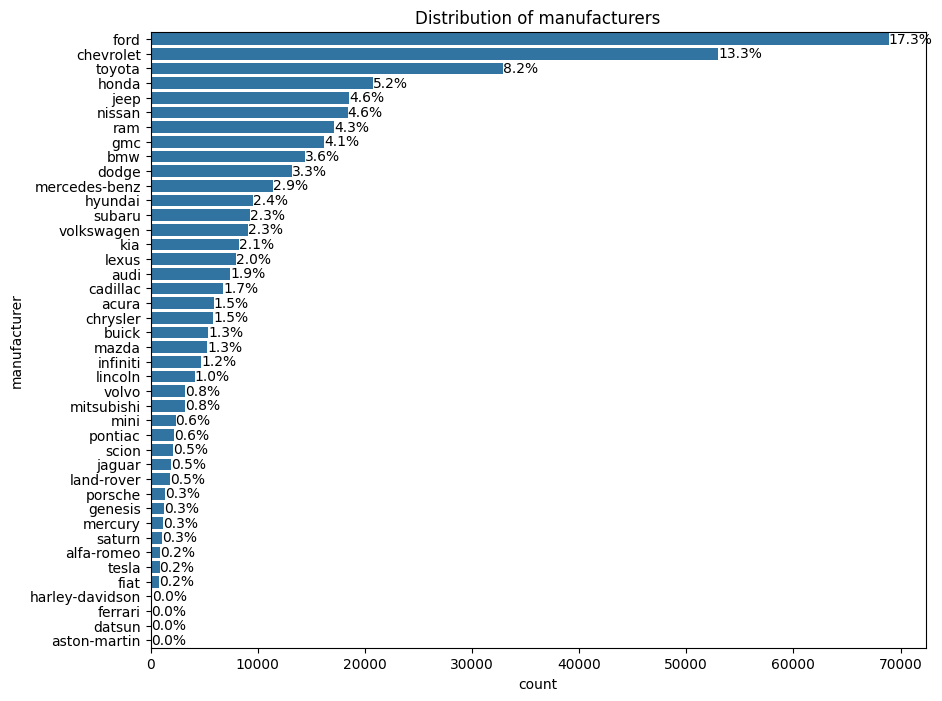

In [18]:
# plot the distribution of 'manufacturer' column
plt.figure(figsize=(10, 8))
sns.countplot(data=cars_df, y='manufacturer', order=cars_df['manufacturer'].value_counts().index)
plt.title('Distribution of manufacturers')
# show % on each bar of the plot
for i in range(cars_df['manufacturer'].nunique()):
    count = cars_df['manufacturer'].value_counts().values[i]
    pct_string = f'{count / len(cars_df) * 100:.1f}%'
    plt.text(count, i, pct_string, va='center')
plt.show()

In [19]:
# Define categories for 'manufacturer' column
standard_category = ['scion', 'ford', 'chevrolet', 'toyota', 'honda', 'nissan', 'jeep', 'ram', 'gmc', 'dodge', 'hyundai', 'subaru', 'volkswagen', 'kia', 'buick', 'mazda', 'mini', 'mitsubishi', 'chrysler', 'pontiac', 'fiat', 'mercury', 'saturn', 'harley-davidson', 'datsun']
premium_category = ['genesis', 'tesla', 'bmw', 'mercedes-benz', 'lexus', 'cadillac', 'lincoln', 'audi', 'acura', 'infiniti', 'volvo', 'porsche', 'land-rover', 'jaguar', 'alfa-romeo', 'aston-martin', 'morgan']
exotic_category = ['ferrari']


In [20]:
# Sample data for a manufacturer
cars_df[cars_df['manufacturer'] == 'mercedes-benz'].sample(5)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
id,,,,,,,,,,,,,,,
7311292310,new hampshire,14995,2013.0,mercedes-benz,benz c300,like new,6 cylinders,gas,70876.0,clean,automatic,4wd,sedan,black,nh
7310070867,philadelphia,0,2013.0,mercedes-benz,m-class,NaN,NaN,gas,77274.0,clean,automatic,NaN,other,black,pa
7309343061,east idaho,8199,2010.0,mercedes-benz,benz c300 4matic,excellent,6 cylinders,gas,166000.0,clean,automatic,4wd,sedan,grey,id
7316297871,sacramento,7000,2010.0,mercedes-benz,e350,good,6 cylinders,gas,63752.0,rebuilt,automatic,rwd,sedan,black,ca
7311376020,ann arbor,29990,2012.0,mercedes-benz,c-class c 63 amg,good,NaN,other,95762.0,clean,other,NaN,coupe,black,mi


#### Impute and encode values for **condition** column

In [21]:
# percentage of values in 'condition' column
cars_df['condition'].value_counts(dropna=False) / len(cars_df) * 100

condition
NaN          39.834712
good         29.307843
excellent    23.937374
like new      5.017283
fair          1.487187
new           0.282247
salvage       0.133353
Name: count, dtype: float64

In [22]:
# fill missing values in 'condition' column with 'good' based on the percentage of values
condition_fill = cars_df['condition'].value_counts().idxmax()
cars_df['condition'] = cars_df['condition'].fillna(condition_fill)

cars_df['condition'].value_counts(dropna=False) / len(cars_df) * 100

condition
good         69.142555
excellent    23.937374
like new      5.017283
fair          1.487187
new           0.282247
salvage       0.133353
Name: count, dtype: float64

In [23]:
# Encode 'condition' column; 'salvage'=0, 'fair'=1, 'good'=2, 'excellent'=3, 'like new'=4, 'new'=5
condition_map = {'salvage': 0, 'fair': 1, 'good': 2, 'excellent': 3, 'like new': 4, 'new': 5}
cars_df['condition'] = cars_df['condition'].map(condition_map)

#### Encode values for **title_status** column

In [24]:
# Encode title_status to 1 if 'clean' and 0 if 'salvage'
cars_df['clean_title'] = cars_df['title_status'].apply(lambda x: 1 if x == 'clean' else 0)

# Drop 'title_status' column
cars_df = cars_df.drop(columns='title_status')

### Deal with any other missing values

In [25]:
# % of missing values in all other columns
missing_values_percentage = cars_df.isna().sum() / len(cars_df) * 100
missing_values_percentage


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
model            0.000000
condition        0.000000
cylinders       41.030127
fuel             0.000000
odometer         0.000000
transmission     0.000000
drive           29.857799
type            20.834409
paint_color     29.778589
state            0.000000
clean_title      0.000000
dtype: float64

In [26]:
# Drop all columns with over 20% missing values
cars_df = cars_df.drop(columns=missing_values_percentage[missing_values_percentage > 20].index)


In [27]:
# Show unique values count for 'model'
cars_df['model'].value_counts(dropna=False)

model
f-150                  7814
silverado 1500         5009
1500                   4155
camry                  3064
silverado              2946
                       ... 
boxter 986                1
sable wagon premium       1
rav 4 128k                1
rl sh-awd w/navi          1
gand wagoneer             1
Name: count, Length: 23026, dtype: int64

Notice that there are over 5000 unique values for **model**.  We'll drop **model**, **state**, and **region** columns as the sheer number of unique values in each make them not as useful even when encoded.

In [28]:
# Drop columns 'model', 'state', 'region'
cars_df = cars_df.drop(columns=['model', 'state', 'region'])

In [29]:
# % of missing values for each column
missing_values_percentage = cars_df.isna().sum() / len(cars_df) * 100
missing_values_percentage

price           0.0
year            0.0
manufacturer    0.0
condition       0.0
fuel            0.0
odometer        0.0
transmission    0.0
clean_title     0.0
dtype: float64

#### Summary of all unique values and their count

In [30]:
for column in ['condition', 'fuel', 'transmission']:
    print(f'{cars_df[column].value_counts(dropna=False)}\n')

condition
2    275838
3     95496
4     20016
1      5933
5      1126
0       532
Name: count, dtype: int64

fuel
gas         337858
other        29105
diesel       25332
hybrid        5058
electric      1588
Name: count, dtype: int64

transmission
automatic    316014
other         61513
manual        21414
Name: count, dtype: int64



In [31]:
cars_df['manufacturer'].value_counts(dropna=False)

manufacturer
ford               68885
chevrolet          52997
toyota             32895
honda              20760
jeep               18510
nissan             18402
ram                17148
gmc                16208
bmw                14447
dodge              13190
mercedes-benz      11399
hyundai             9542
subaru              9308
volkswagen          9127
kia                 8254
lexus               8020
audi                7440
cadillac            6760
acura               5884
chrysler            5837
buick               5361
mazda               5316
infiniti            4722
lincoln             4104
volvo               3256
mitsubishi          3187
mini                2341
pontiac             2230
scion               2120
jaguar              1910
land-rover          1800
porsche             1319
genesis             1240
mercury             1164
saturn              1057
alfa-romeo           888
tesla                849
fiat                 779
harley-davidson      124
ferrari     

### Check for abnormal values

In [32]:
# Find highest price for each manufacturer
highest_price = cars_df.groupby('manufacturer')['price'].max()
highest_price


manufacturer
acura                  139999
alfa-romeo              62950
aston-martin           179888
audi                   160000
bmw                    138000
buick               123456789
cadillac               195000
chevrolet           123456789
chrysler               655000
datsun                  30000
dodge                 6995495
ferrari                349999
fiat                    32500
ford               1111111111
genesis                 47590
gmc                 123456789
harley-davidson         39900
honda                  123456
hyundai                 50000
infiniti                69995
jaguar                 150000
jeep               1410065407
kia                     55325
land-rover             129888
lexus                  114950
lincoln               1234567
mazda                   45000
mercedes-benz      3024942282
mercury                 60000
mini                    42500
mitsubishi              39999
nissan              135008900
pontiac                 980

In [33]:
# Find all rows where price is > 400000
cars_df[cars_df['price'] > 400000]


,price,year,manufacturer,condition,fuel,odometer,transmission,clean_title
id,,,,,,,,
7315961634,99999999,1993.0,ford,2,gas,99999.0,automatic,1
7305265540,1111111111,1999.0,ford,2,diesel,149000.0,automatic,1
7302895209,2000000,2002.0,saturn,2,gas,164290.0,automatic,1
7313479931,655000,2010.0,chrysler,2,gas,106000.0,automatic,1
7309730903,3024942282,2000.0,mercedes-benz,2,gas,100000.0,automatic,1
7311936036,990000,2017.0,mercedes-benz,2,gas,4085.0,automatic,1
7314124996,6995495,2014.0,dodge,2,gas,135888.0,automatic,1
7316029298,425000,1993.0,jeep,2,gas,380.0,automatic,1
7316047597,17000000,2007.0,ram,2,diesel,170000.0,automatic,0


In [34]:
# Find number of rows where price is > $400,000
print('Number of rows where price > $400,000:')
print(len(cars_df[cars_df['price'] > 400000]))

# Drop rows where price is > $400,000
cars_df = cars_df[cars_df['price'] <= 400000]


Number of rows where price > $400,000:
35


In [35]:
# Find lowest price for each manufacturer
highest_price = cars_df.groupby('manufacturer')['price'].min()
highest_price

manufacturer
acura              0
alfa-romeo         0
aston-martin       0
audi               0
bmw                0
buick              0
cadillac           0
chevrolet          0
chrysler           0
datsun             1
dodge              0
ferrari            0
fiat               0
ford               0
genesis            0
gmc                0
harley-davidson    0
honda              0
hyundai            0
infiniti           0
jaguar             0
jeep               0
kia                0
land-rover         0
lexus              0
lincoln            0
mazda              0
mercedes-benz      0
mercury            0
mini               0
mitsubishi         0
nissan             0
pontiac            0
porsche            0
ram                0
saturn             0
scion              0
subaru             0
tesla              0
toyota             0
volkswagen         0
volvo              0
Name: price, dtype: int64

In [36]:
# Find number of rows where price <= 0
print('Number of rows where price <= $0:')
# Print number of rows where price <= 0
print(len(cars_df[cars_df['price'] <= 0]))

# Drop rows where price <= 0
cars_df = cars_df[cars_df['price'] > 0]


Number of rows where price <= $0:
28770


In [37]:
# Find the highest 'odomoeter' value for each 'manufacturer'
highest_odometer = cars_df.groupby('manufacturer')['odometer'].max()
highest_odometer


manufacturer
acura               8888888.0
alfa-romeo           396541.0
aston-martin          39648.0
audi                2319010.0
bmw                 2915272.0
buick               9999999.0
cadillac            9999999.0
chevrolet          10000000.0
chrysler            1560000.0
datsun               215000.0
dodge              10000000.0
ferrari               80000.0
fiat                 636200.0
ford               10000000.0
genesis              203000.0
gmc                 9999999.0
harley-davidson      229726.0
honda               9999999.0
hyundai             9999999.0
infiniti             299350.0
jaguar               300000.0
jeep               10000000.0
kia                  999999.0
land-rover           308000.0
lexus              10000000.0
lincoln             1422929.0
mazda               9999999.0
mercedes-benz       9999999.0
mercury             1600009.0
mini                 760000.0
mitsubishi           999999.0
nissan              2346897.0
pontiac             9999999

In [38]:
# Find number of rows where odometer > 400,000
print('Number of rows where odometer > 400,000:')
# Print number of rows where odometer > 400,000
print(len(cars_df[cars_df['odometer'] > 400000]))

# Drop rows where odometer > 400,000:
cars_df = cars_df[cars_df['odometer'] <= 400000]

Number of rows where odometer > 400,000:
807


### Feature Engineering

In [39]:
# Add column for log of 'price' 
cars_df['log_price'] = np.log(cars_df['price'])

# Add column for 'age' of car
cars_df['age'] = 2024 - cars_df['year']

# Drop 'year' column
cars_df = cars_df.drop(columns='year')


In [40]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369329 entries, 7316814884 to 7301591129
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         369329 non-null  int64  
 1   manufacturer  369329 non-null  object 
 2   condition     369329 non-null  int64  
 3   fuel          369329 non-null  object 
 4   odometer      369329 non-null  float64
 5   transmission  369329 non-null  object 
 6   clean_title   369329 non-null  int64  
 7   log_price     369329 non-null  float64
 8   age           369329 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 28.2+ MB


In [41]:
# One-hot encode 'fuel', 'transmission'
cars_df = pd.get_dummies(cars_df, columns=['fuel', 'transmission'], dtype=float)


In [42]:
# Frequency encoding for 'manufacturer'
manufacturer_freq = cars_df['manufacturer'].value_counts() / len(cars_df)
cars_df['manufacturer_frequency_encoding'] = cars_df['manufacturer'].map(manufacturer_freq)


In [43]:
# Leave one-out target encode 'manufacturer' column
# Calculate mean price for each manufacturer
manufacturer_target = cars_df.groupby('manufacturer')['price'].transform('mean')

# Calculate number of times each manufacturer appears in the dataset
manufacturer_count = cars_df['manufacturer'].map(cars_df['manufacturer'].value_counts())

# Calculate leave-one-out target encoding
cars_df['manufacturer_LOO_encoding'] = (manufacturer_target * manufacturer_count - cars_df['price']) / (manufacturer_count - 1)


In [45]:
cars_df.query('manufacturer == "ferrari"')[['manufacturer', 'price', 'manufacturer_LOO_encoding', 'manufacturer_frequency_encoding']].sample(5)

,manufacturer,price,manufacturer_LOO_encoding,manufacturer_frequency_encoding
id,,,,
7306188905,ferrari,116899,133375.500000,0.000171
7312873837,ferrari,44150,134548.870968,0.000171
7304143214,ferrari,227995,131583.629032,0.000171
7315260116,ferrari,98900,133665.806452,0.000171
7314331466,ferrari,347999,129648.080645,0.000171


In [46]:
cars_df.sample(5)

,price,manufacturer,condition,odometer,clean_title,log_price,age,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_automatic,transmission_manual,transmission_other,manufacturer_frequency_encoding,manufacturer_LOO_encoding
id,,,,,,,,,,,,,,,,,
7316293313,15999,infiniti,2,40839.0,1,9.680281,20.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.011962,21109.056826
7316659088,12250,nissan,2,96500.0,1,9.413281,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.045737,12909.494997
7308077640,4988,ford,2,204142.0,1,8.514790,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.170612,21038.869753
7315308063,17900,mercedes-benz,2,83000.0,1,9.792556,21.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.027266,21598.463800
7313310733,36782,gmc,3,52300.0,1,10.512764,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.040341,25219.830246


In [47]:
# Drop 'manufacturer' column
cars_df_cleaned = cars_df.drop(columns='manufacturer')


#### Plots

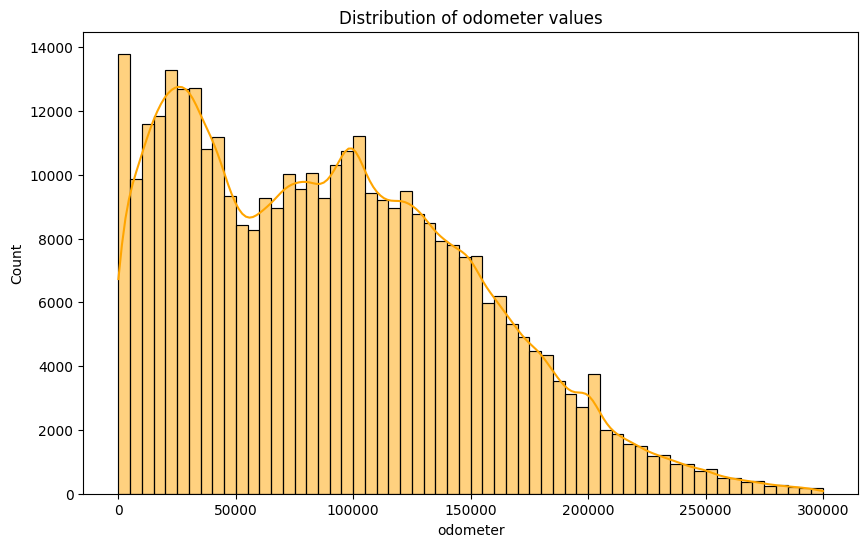

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(cars_df_cleaned.query('odometer < 300000'), x="odometer", kde=True, bins=60, color='orange' )
plt.title('Distribution of odometer values')
plt.show()


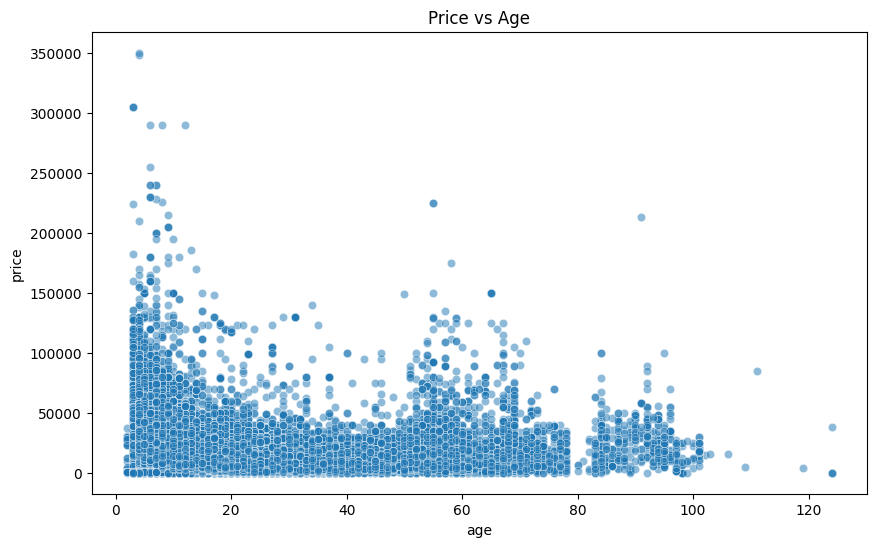

In [49]:
# Plot price vs year
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cars_df_cleaned, x='age', y='price', alpha=0.5)
plt.title('Price vs Age')
plt.show()


#### Plot correlation matrix

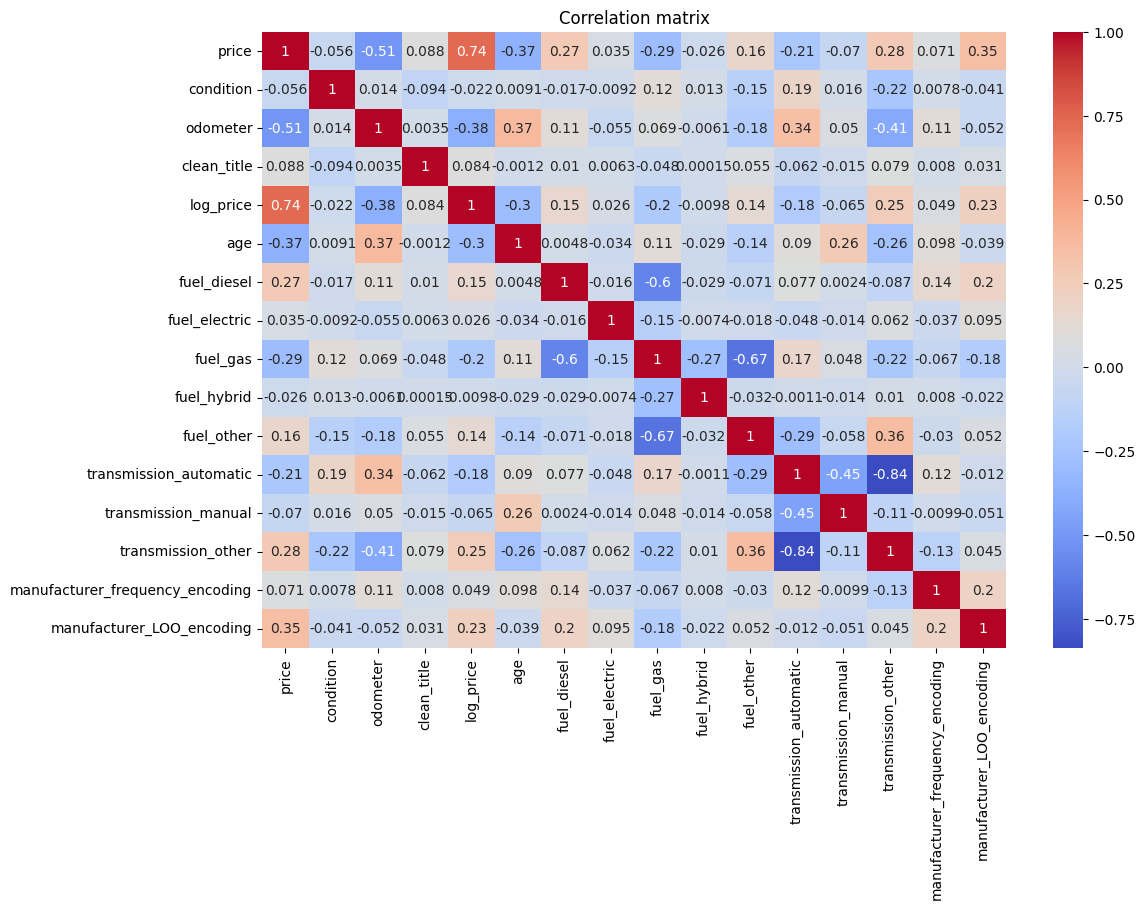

In [50]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cars_df_cleaned.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


In [ ]:
#sns.pairplot(cars_df_cleaned, diag_kind='kde')


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.